In [37]:
import pandas as pd
import geopandas as gpd

# Load data
df = pd.read_csv("sample_new_zealand. csv")

# Convert Datetime column
df['Datetime'] = pd.to_datetime(df['Datetime'])
df['Timediff'] = ((df['Datetime'] - df['Datetime'].min()).dt.total_seconds())/86400

# Make GeoDataFrame with lon/lat
gdf = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df['Lon'], df['Lat']),
    crs="EPSG:4326"   # WGS84 (lat/lon)
)

# Project to UTM (auto-detect zone for centroid of data)
gdf = gdf.to_crs(gdf.estimate_utm_crs())

# Extract projected coordinates (in meters)
df['x'] = gdf.geometry.x   # Easting
df['y'] = gdf.geometry.y   # Northing

# Build feature matrix
features = df[['x', 'y', 'Timediff', 'Mag']].values
print(features)

[[ 4.82705926e+05 -6.63502250e+06  0.00000000e+00  6.20000000e+00]
 [ 5.23112588e+05 -6.66049882e+06  4.20557870e-01  6.10000000e+00]
 [ 1.72375826e+06 -4.93575159e+06  1.10326201e+02  6.60000000e+00]
 ...
 [ 6.91713536e+05 -6.35275638e+06  1.64023911e+04  5.10000000e+00]
 [ 6.72592278e+05 -6.38305638e+06  1.64096128e+04  5.10000000e+00]
 [ 6.03847264e+05 -6.44942301e+06  1.64155815e+04  5.10000000e+00]]


In [38]:
# Data Normalisation
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(features)
print(features_scaled)

[[6.64242072e-02 1.72950599e-02 0.00000000e+00 5.42857143e-01]
 [8.24477417e-02 6.83459197e-03 2.56194317e-05 5.14285714e-01]
 [5.58571884e-01 7.15008469e-01 6.72082199e-03 6.57142857e-01]
 ...
 [1.49307586e-01 1.33192329e-01 9.99196470e-01 2.28571429e-01]
 [1.41724922e-01 1.20751277e-01 9.99636400e-01 2.28571429e-01]
 [1.14463622e-01 9.35014183e-02 1.00000000e+00 2.28571429e-01]]


In [39]:
# Tuning the cluster_selection_epsilon
from sklearn.cluster import HDBSCAN
import numpy as np

eps_values = [0.0, 0.05, 0.1, 0.2, 0.5, 1.0]

for eps in eps_values:
    clusterer = HDBSCAN(min_cluster_size=2,
                        cluster_selection_epsilon=eps,
                        min_samples=2)
    labels = clusterer.fit_predict(features_scaled)
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    noise_frac = np.mean(labels == -1)
    print(f"epsilon={eps}, clusters={n_clusters}, noise={noise_frac:.2f}")

epsilon=0.0, clusters=406, noise=0.23
epsilon=0.05, clusters=182, noise=0.12
epsilon=0.1, clusters=28, noise=0.02
epsilon=0.2, clusters=5, noise=0.00
epsilon=0.5, clusters=2, noise=0.00
epsilon=1.0, clusters=2, noise=0.00


In [40]:
from sklearn.cluster import HDBSCAN

# Initialize the HDBSCAN model
hdb = HDBSCAN(min_cluster_size=2,
              cluster_selection_epsilon=0.05
              )
hdb.fit(features_scaled)

,min_cluster_size,2
,min_samples,None
,cluster_selection_epsilon,0.05
,max_cluster_size,None
,metric,'euclidean'
,metric_params,None
,alpha,1.0
,algorithm,'auto'
,leaf_size,40
,n_jobs,None
,cluster_selection_method,'eom'


In [41]:
# Add the resulting cluster labels to the original DataFrame
df['Cluster'] = hdb.labels_

# Count the number of points in each cluster
# This helps understand the distribution of the data
print("--- Cluster ID counts ---")
print(df['Cluster'].value_counts())

--- Cluster ID counts ---
Cluster
 180    732
-1      184
 140     27
 77      21
 49      16
       ... 
 23       2
 179      2
 28       2
 97       2
 65       2
Name: count, Length: 183, dtype: int64


In [42]:
# Classify mainshock, dependent shock and noise in each cluster
# Add a new column for the classification of each event
df['Type'] = 'Dependent'  # Initialize all as Unclassified

# Loop through each cluster (excluding noise: -1)
for cluster_id in sorted(df['Cluster'].unique()):
    if cluster_id == -1: # if cluster id is not equal to -1
        continue  # skip noise

    sub_df = df[df['Cluster'] == cluster_id]  # Make each cluster as a subset from the whole dataframe

    # Identify the mainshock (largest magnitude)
    mainshock_idx = sub_df['Mag'].idxmax()
    mainshock_time = sub_df.at[mainshock_idx, 'Datetime']

    # Assign mainshock
    df.at[mainshock_idx, 'Type'] = 'Mainshock'

# Assign noise (they might be independent shocks)
df.loc[df['Cluster'] == -1, 'Type'] = 'Noise'

print(df)

            Date    Lat     Lon  Depth  Mag  Strike  Dip  Rake        Time  \
0     1976/01/15 -30.38 -176.82   33.0  6.2     196   26    91  06:06:46.1   
1     1976/01/15 -30.15 -177.24   33.0  6.1     180   10    73  16:12:22.3   
2     1976/05/04 -44.64  167.57   19.0  6.6      57   18   136  13:56:29.9   
3     1976/06/29 -33.82 -177.83   48.0  6.1      24   37    78  18:30:09.1   
4     1976/07/31 -30.32 -177.96   20.0  6.2     196   31    93  00:46:58.0   
...          ...    ...     ...    ...  ...     ...  ...   ...         ...   
1537  2020/11/29 -31.86  179.20  462.5  5.3     115   35  -178  21:45:22.7   
1538  2020/12/10 -32.88 -179.85   96.0  5.9     139   25   175  20:42:08.3   
1539  2020/12/11 -32.91 -179.05   43.5  5.1     206   34   104  15:30:00.1   
1540  2020/12/18 -32.64 -178.84   35.7  5.1     198   32    97  20:49:15.8   
1541  2020/12/24 -32.05 -178.10   10.0  5.1     197   28    77  20:04:11.8   

                    Datetime      Timediff             x       

In [43]:
df['Type'].unique()

array(['Dependent', 'Noise', 'Mainshock'], dtype=object)

In [44]:
# ========================================
# Estimation and further data exploration
# ========================================

In [45]:
# Visualise the clustered sequence on map
import plotly.express as px

df_noise_excluded = df[df['Type'] != 'Noise']
df_noise_excluded['Cluster'] = df_noise_excluded['Cluster'].astype('category')

fig = px.scatter_map(
    df_noise_excluded,
    lat='Lat',
    lon='Lon',
    hover_name='Cluster',
    color='Cluster',
    hover_data={'Date', 'Time', 'Lat', 'Lon'},
    center={'lat': -41, 'lon': 174},
    zoom=3.8,
    height=800,
    map_style='carto-positron',
    title='Earthquake Clustering using HDBSCAN <br><sup>Time of occurrence: 1976-2020 | New Zealand and its surrounding area</sup>'
)

fig.show()

/var/folders/fn/9d0nx8h147x36gzgyptphd8w0000gn/T/ipykernel_42630/1074453884.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [46]:
# Extract the mainshock sequence
declustered_mainshock_hdbscan = df[(df['Type'] == 'Mainshock')].copy()

# Compute inter-arrival timesCompute inter-arrival times to second
declustered_mainshock_hdbscan['inter_arrival'] = declustered_mainshock_hdbscan['Datetime'].diff().dt.total_seconds()
print(declustered_mainshock_hdbscan)

            Date    Lat     Lon  Depth  Mag  Strike  Dip  Rake        Time  \
3     1976/06/29 -33.82 -177.83   48.0  6.1      24   37    78  18:30:09.1   
13    1977/11/21 -31.45 -179.89  324.0  5.2      64   50   -17  09:52:38.6   
18    1978/02/11 -30.41 -177.12   33.0  6.6     202   44    82  00:05:23.0   
28    1979/03/24 -42.07  171.70   59.0  5.3     345   57     9  21:06:53.6   
29    1979/04/19 -37.95  176.77   33.0  5.1       4   44  -138  18:01:13.0   
...          ...    ...     ...    ...  ...     ...  ...   ...         ...   
1501  2020/04/26 -44.94  167.55   80.1  5.0       2   33    37  22:52:11.3   
1507  2020/06/18 -33.29 -177.86   10.0  7.4     124   66  -160  12:49:53.8   
1515  2020/06/24 -44.64  167.47    9.7  5.6      51   33   129  22:20:02.0   
1524  2020/08/24 -30.10 -177.17   10.0  4.5     176   43    76  23:55:30.7   
1536  2020/11/21 -47.33  165.51   10.0  4.7      30   71  -174  18:00:54.6   

                    Datetime      Timediff             x       

In [47]:
# The Statistic Features of the Mainshock Sequence
print("The declustered catalogue contains {} events.".format(len(declustered_mainshock_hdbscan)))

max_interval_days = round(declustered_mainshock_hdbscan['inter_arrival'].max() / (24*60*60))
print("The maximum interarrival time between two neighbour independent events is {} days.".format(max_interval_days))

min_interval_min = round(declustered_mainshock_hdbscan['inter_arrival'].min() / 60)
print("The minimum interarrival time between two neighbour independent events is {} minutes.".format(min_interval_min))

The declustered catalogue contains 182 events.
The maximum interarrival time between two neighbour independent events is 510 days.
The minimum interarrival time between two neighbour independent events is 37 minutes.


In [48]:
# Visualise the declustered mainshock sequence on map
import plotly.express as px

fig_mainshock = px.scatter_map(
    declustered_mainshock_hdbscan,
    lat='Lat',
    lon='Lon',
    hover_name='Mag',
    size='Mag',
    size_max=8,
    color='Mag',
    color_continuous_scale='orrd',
    hover_data={'Date', 'Time', 'Lat', 'Lon'},
    center={'lat': -41, 'lon': 174},
    zoom=3.8,
    height=800,
    map_style='carto-positron',
    title='Declustered Mainshock Sequence of New Zealand using HDBSCAN<br><sup>Time of occurrence: 1976-2020</sup>'
)

fig_mainshock.show()

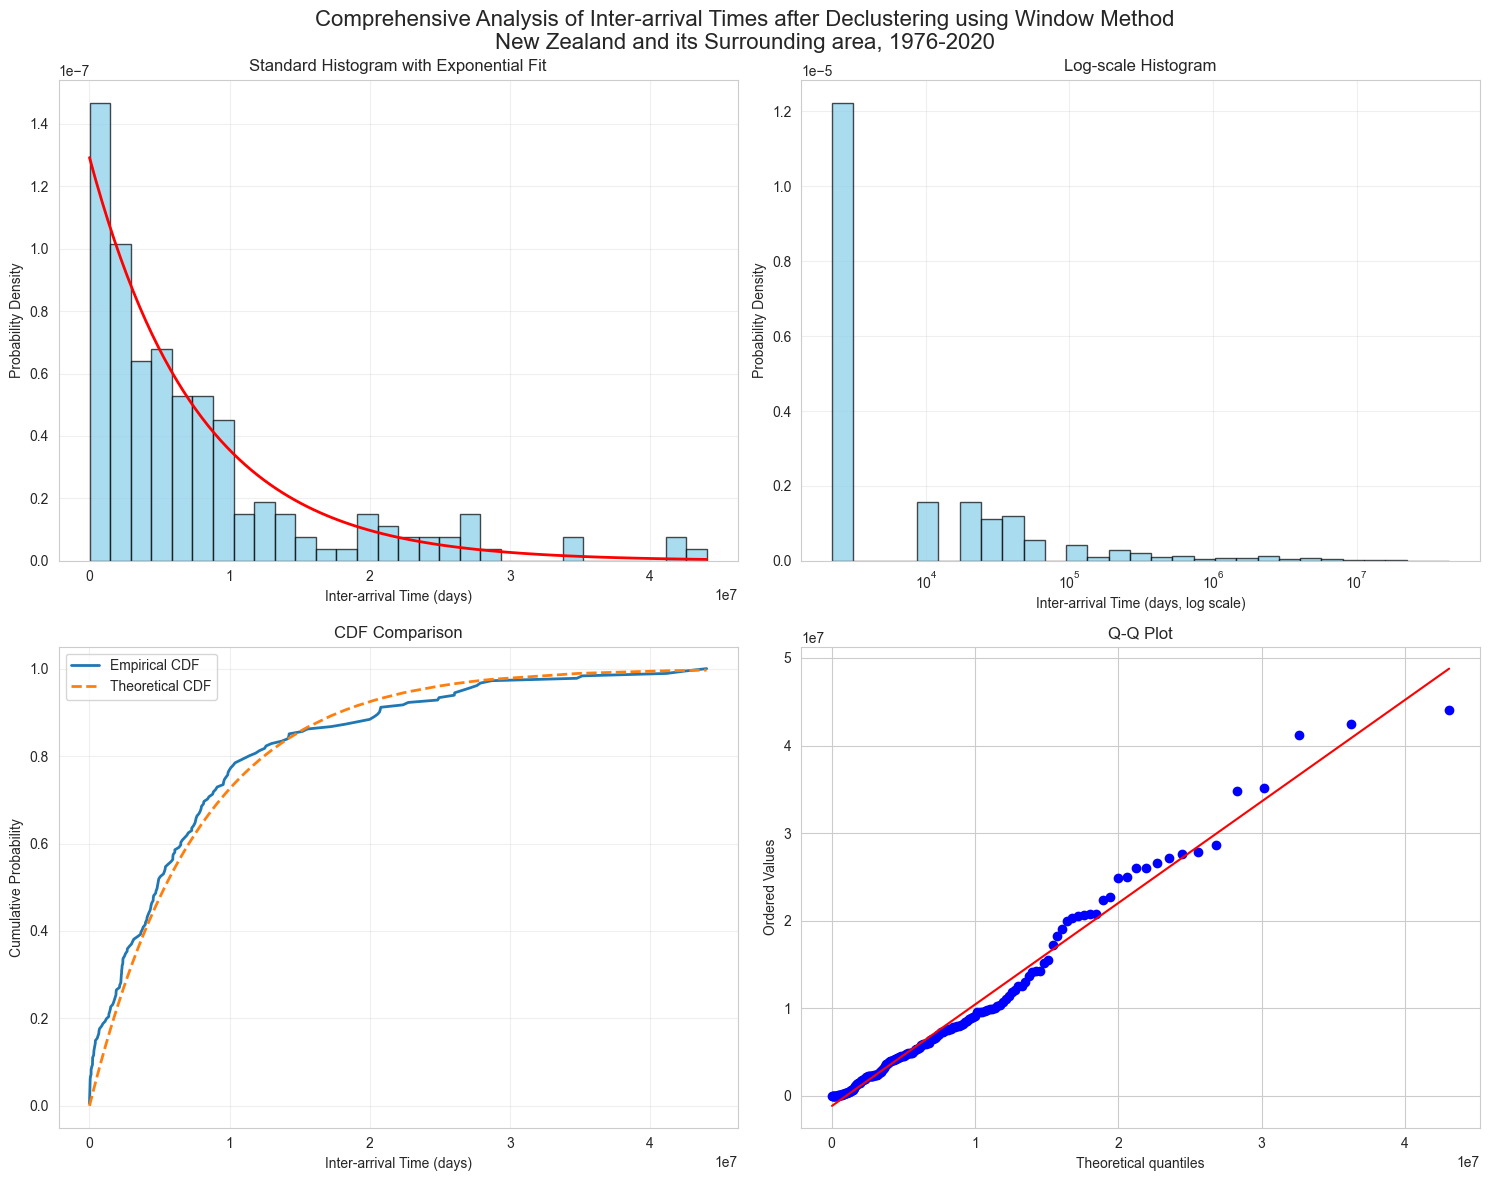

In [54]:
# Visualisation: The inter_arrival times are expected to fit an exponential distribution
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import expon
from scipy.stats import probplot

x = declustered_mainshock_hdbscan['inter_arrival'].dropna()
loc, scale = expon.fit(x)

# Comprehensive analysis for the raw catalogue
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Standard Histogram with Exponential Fit (Top-Left)
axes[0, 0].hist(x, bins=30, density=True, alpha=0.7, color='skyblue', edgecolor='black')
x_range = np.linspace(x.min(), x.max(), 100)
axes[0, 0].plot(x_range, expon.pdf(x_range, loc, scale), 'r-', lw=2)
axes[0, 0].set_title('Standard Histogram with Exponential Fit')
axes[0, 0].set_xlabel('Inter-arrival Time (days)')
axes[0, 0].set_ylabel('Probability Density')
axes[0, 0].grid(True, alpha=0.3)

# Log-scale Histogram (Top-Right)
bins = np.logspace(np.log10(x.min()), np.log10(x.max()), 30)
axes[0, 1].hist(x, bins=bins, density=True, alpha=0.7, color='skyblue', edgecolor='black')
axes[0, 1].set_xscale('log')
axes[0, 1].set_title('Log-scale Histogram')
axes[0, 1].set_xlabel('Inter-arrival Time (days, log scale)')
axes[0, 1].set_ylabel('Probability Density')
axes[0, 1].grid(True, alpha=0.3)

# CDF Comparison (Bottom-Left)
x_sorted = np.sort(x)
y_ecdf = np.arange(1, len(x_sorted)+1) / len(x_sorted)
y_theoretical = expon.cdf(x_sorted, loc, scale)
axes[1, 0].plot(x_sorted, y_ecdf, label='Empirical CDF', linewidth=2)
axes[1, 0].plot(x_sorted, y_theoretical, label='Theoretical CDF', linestyle='--', linewidth=2)
axes[1, 0].set_title('CDF Comparison')
axes[1, 0].set_xlabel('Inter-arrival Time (days)')
axes[1, 0].set_ylabel('Cumulative Probability')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Q-Q Plot (Bottom-Right)
probplot(x, dist=expon, sparams=(loc, scale), plot=axes[1, 1])
axes[1, 1].set_title('Q-Q Plot')

plt.savefig('comprehensive_analysis_new_zealand_hdbscan.png', dpi=300, bbox_inches='tight')
plt.suptitle('Comprehensive Analysis of Inter-arrival Times after Declustering using Window Method\nNew Zealand and its Surrounding area, 1976-2020', fontsize=16)
plt.tight_layout()
plt.show()

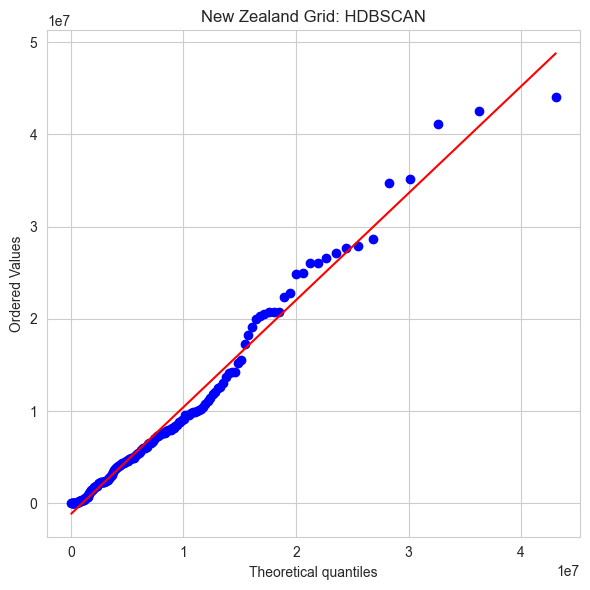

In [50]:
import matplotlib.pyplot as plt
from scipy.stats import expon
from scipy.stats import probplot

x = declustered_mainshock_hdbscan['inter_arrival'].dropna()
loc, scale = expon.fit(x)

plt.figure(figsize=(6, 6))
probplot(x, dist=expon, sparams=(loc, scale), plot=plt)
plt.title("New Zealand Grid: HDBSCAN")
plt.tight_layout()
plt.savefig("qq_new_zealand_hdbscan.png", dpi=300)
plt.show()

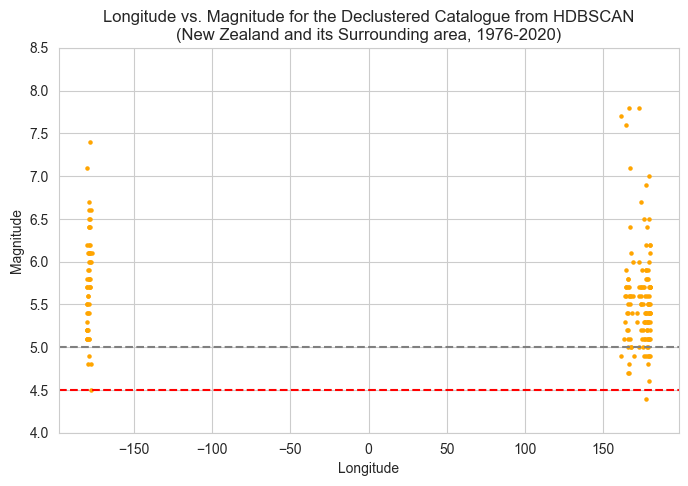

In [51]:
# Lon vs Mag
import matplotlib.pyplot as plt

x = declustered_mainshock_hdbscan['Lon']
y = declustered_mainshock_hdbscan['Mag']

plt.figure(figsize=(8, 5))
plt.ylim(4, 8.5)
plt.scatter(x, y, s=5, color='orange')
plt.axhline(y=4.5, color='red', linestyle='--')  # Observing the minor magnitude(<4.5) events for comparison
plt.axhline(y=5, color='grey', linestyle='--')  # Observing the minor magnitude events(<5) for comparison
plt.xlabel("Longitude")
plt.ylabel("Magnitude")
plt.title("Longitude vs. Magnitude for the Declustered Catalogue from HDBSCAN\n(New Zealand and its Surrounding area, 1976-2020)")
plt.show()

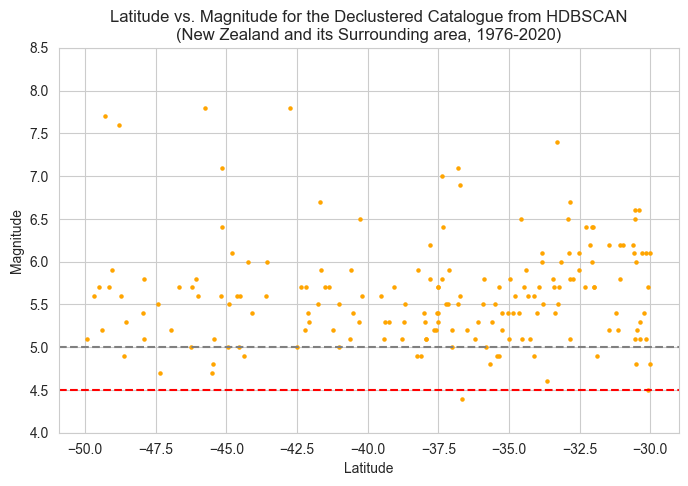

In [52]:
# Lat vs Mag
import matplotlib.pyplot as plt

x = declustered_mainshock_hdbscan['Lat']
y = declustered_mainshock_hdbscan['Mag']

plt.figure(figsize=(8, 5))
plt.ylim(4, 8.5)
plt.scatter(x, y, s=5, color='orange')
plt.axhline(y=4.5, color='red', linestyle='--')  # Observing the minor magnitude(<4.5) events for comparison
plt.axhline(y=5, color='grey', linestyle='--')  # Observing the minor magnitude events(<5) for comparison
plt.xlabel("Latitude")
plt.ylabel("Magnitude")
plt.title("Latitude vs. Magnitude for the Declustered Catalogue from HDBSCAN\n(New Zealand and its Surrounding area, 1976-2020)")
plt.savefig('lat_mag_hdbscan.png', dpi=300)
plt.show()

In [53]:
# KS test
from scipy.stats import kstest, expon

x = declustered_mainshock_hdbscan['inter_arrival'].dropna()
loc, scale = expon.fit(x)

stat, p_value = kstest(x, 'expon', args=(loc, scale))

# If p_value > 0.05, the inter-arrival times are consistent with an exponential distribution.
# This implies that the earthquake occurrences follow a Poisson process.
print(f"K-S test p-value: {p_value:.4f}")
print(f"K-S Test Statistic (D): {stat:.4f}")

METHOD_NAME = "HDBSCAN"
if p_value > 0.05:
    # We fail to reject the null hypothesis.
    print(f"The declustered catalogue from the {METHOD_NAME} method is consistent with a Poisson process.")
else:
    # We reject the null hypothesis.
    print(f"The declustered catalogue from the {METHOD_NAME} method is not consistent with a Poisson process.")

K-S test p-value: 0.0637
K-S Test Statistic (D): 0.0966
The declustered catalogue from the HDBSCAN method is consistent with a Poisson process.
